*This tutorial is based on the LangGraph course on Langchain Academy*

**Goal:** Provide an introductory understanding of building Agentic systems with LangGraph.


**Links:**
* [LG Academy Repo](https://github.com/langchain-ai/langchain-academy)
* [LG Python Documentation](https://langchain-ai.github.io/langgraph/)
* [LangGraph](https://www.langchain.com/langgraph)


### **What is LangGraph?**
> LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. As a very low-level framework, it provides fine-grained control over both the flow and state of your application, crucial for creating reliable agents. Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features.


1. **Cycles and Branching** - Implement loops and conditionals in applications
2. **Persistence** - Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more
3. **Human-in-the-Loop** - Interrupt graph execution to approve or edit next action planned by the agent
4. **Streaming Support** - Stream outputs as they are produced by each node (including token streaming)
5. **Integration with LangChain** - LangGraph integrates seamlessly with LangChain and LangSmith

*You can also check out this [course](https://academy.langchain.com/courses/take/intro-to-langgraph/) that this tutorial is based on.*

For more examples any many implementations of different agentic workflows that you can use as starting point for your projects, please check out the LangGraph [tutorials](https://langchain-ai.github.io/langgraph/tutorials/) and [how-to guides](https://langchain-ai.github.io/langgraph/how-tos/).

### Groq and Tavily API Keys

Next, we need an API key from [groq.com](https://groq.com/) to use a powerful opensource LLMs for free. Groq offers a free tier allowing for API access with rate limits You can register here if you do not have an account yet: https://huggingface.co/login

After registering, you can create your key [here](https://console.groq.com/keys)

![image.png](images\groc_limits.png)

Apart from groq, we will use a web search tool ([Tavily](https://tavily.com/)) that abstracts away the parsing of HTML code and gives us 1000 free searches per month.

After registering, you can create your key [here](https://app.tavily.com/home).

Once you have your keys, you have two options to use them in this notebook:

1. For directly inputting the tokens via copy/pasting:

In [1]:
# import getpass
# import os

# if not os.getenv("GROQ_API_KEY"):
#     os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your token: ")

# if not os.getenv("TAVILY_API_KEY"):
#     os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your token: ")

2. For loading the tokens from an .env file:

In [5]:
from dotenv import load_dotenv
import os

load_dotenv()

if os.getenv("GROQ_API_KEY"):
    print('Groq API Key loaded successfully')
else:
    print('Groq API Key loading failed, please make sure the .env file exists and the spelling is correct')

if os.getenv("TAVILY_API_KEY"):
    print('Tavily API Key loaded successfully')
else:
    print('Tavily API Key loading failed, please make sure the .env file exists and the spelling is correct')

Groq API Key loaded successfully
Tavily API Key loaded successfully


### Installing relevant packages

In [7]:
#%pip install -qU langchain-groq
#%pip install -qU langgraph

### Preparing the model

In this exercise we will use a much more powerful model compared to last time. The Llama3.3 model hosted by Groq with 70B parameters. As agentic workflows require strong reasoning skills as well as an understanding of tools and their execution, smaller models will be insufficient.

In [2]:
import re
import httpx
import os

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

def create_chat_model():
    """
    return ChatGroq(
        model="llama-3.3-70b-versatile",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )
    """
    
    return ChatOpenAI(model="gpt-4o", temperature=0) 
chat_model = create_chat_model()    


## A simple ReAct Agent without LangGraph

Let's first implement a simple ReAct agent without LangGraph

In [7]:
from langchain.schema import HumanMessage, SystemMessage, AIMessage

class Agent:
    # Initilializes the agent and prepares the system message if available
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append(SystemMessage(content=system))
    
    # Logic when calling the agent
    def __call__(self, message):
        self.messages.append(HumanMessage(content=message))
        result = self.execute()
        self.messages.append(AIMessage(content=result))
        return result

    # invoking the LLM with the collected messages and returning the completion
    def execute(self):
        completion = chat_model.invoke(self.messages)
        return completion.content

In [8]:
# The Prompt contains a lot of instruction on how the model should behave
# Most prominently it forces it into the ReAct schema of Thought, Action and Observation
# This is the perfect system message for initializing the agent

prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run exactly one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python, so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look up the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weighs 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

### Preparing the Tools

For this example, the tools will be two python functions that are available to the LLM. One to calcuate a number, the other to get the average weight of a specific dog breed

In [9]:
def calculate(what):
    return eval(what)

def average_dog_weight(name:str) -> str:
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

# prepare a dictionary for the tools
known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

### Putting it all together

Create the agent, run the tools, return the observation and get the final output

In [10]:
abot = Agent(prompt)

In [11]:
result = abot("How much does a toy poodle weigh?")
print(result)

Thought: I should look up the dog's weight using average_dog_weight to find the average weight of a toy poodle.
Action: average_dog_weight: toy poodle
PAUSE


In [13]:
result = average_dog_weight("Toy Poodle")
result

'a toy poodles average weight is 7 lbs'

In [14]:
next_prompt = "Observation: {}".format(result)

In [15]:
abot(next_prompt)

'Answer: A toy poodle weighs 7 lbs.'

In [16]:
# inspect the message history
abot.messages

[SystemMessage(content='You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run exactly one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python, so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look up the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weighs 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs', additional_kwargs={}, response_metadata={}),
 

Now let's make it more interesting

In [17]:
abot = Agent(prompt)

In [18]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
abot(question)

'Thought: To find the combined weight of the two dogs, I need to look up the average weight of a Border Collie and a Scottish Terrier. I can use the average_dog_weight action to get the average weight of each breed and then add them together.\n\nAction: average_dog_weight: Border Collie\nPAUSE'

In [19]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [20]:
abot(next_prompt)

'Thought: Now that I have the average weight of a Border Collie, I need to find the average weight of a Scottish Terrier. I can use the average_dog_weight action again to get this information.\n\nAction: average_dog_weight: Scottish Terrier\nPAUSE'

In [21]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

Observation: Scottish Terriers average 20 lbs


In [22]:
abot(next_prompt)

'Thought: I now have the average weights of both breeds. To find the combined weight, I need to add the weights of the Border Collie and the Scottish Terrier together. I can use the calculate action to do this.\n\nAction: calculate: 37 + 20\nPAUSE'

In [23]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

Observation: 57


In [24]:
abot(next_prompt)

'Thought: The calculation has given me the combined weight of the two dogs.\n\nAnswer: The combined weight of the Border Collie and the Scottish Terrier is 57 lbs.'

We see that it works and the Agent can reason its way to the correct answer while using the tools available. But this was a very manual endeavour, let's make it automatic:

In [25]:
# python regular expression to parse the action
action_re = re.compile('^Action: (\w+): (.*)$')   

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
C:\Users\aasteine\AppData\Local\Temp\ipykernel_19372\2297634647.py:2: SyntaxWarning: invalid escape sequence '\w'
  action_re = re.compile('^Action: (\w+): (.*)$')


In [26]:
# We prepare a function that loops the thought, action, observation cycle max 5 times
# It automatically parses actions and uses the relevant tools
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [27]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

Thought: To find the combined weight of the two dogs, I need to look up the average weight of a Border Collie and a Scottish Terrier. I can use the average_dog_weight action to get the average weight of each breed and then add them together.

Action: average_dog_weight: Border Collie
PAUSE
 -- running average_dog_weight Border Collie
Observation: a Border Collies average weight is 37 lbs
Thought: Now that I have the average weight of a Border Collie, I need to find the average weight of a Scottish Terrier. I can use the average_dog_weight action again to get this information.

Action: average_dog_weight: Scottish Terrier
PAUSE
 -- running average_dog_weight Scottish Terrier
Observation: Scottish Terriers average 20 lbs
Thought: I now have the average weights of both breeds. To find the combined weight, I need to add the weights of the Border Collie and the Scottish Terrier together. I can use the calculate action to do this.

Action: calculate: 37 + 20
PAUSE
 -- running calculate 37 + 

# The Simplest Graph

Let's build a simple graph with 3 nodes and one conditional edge. 

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. 

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [28]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [29]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

## Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [30]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

## Graph Construction

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

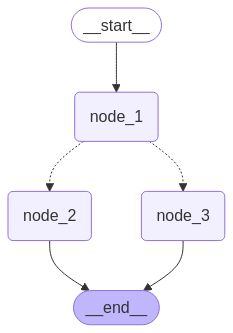

In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [32]:
for i in range(5):
    print(graph.invoke({"graph_state" : "Hi, this is Aaron."}))
    print("-------------------------")

---Node 1---
---Node 3---
{'graph_state': 'Hi, this is Aaron. I am sad!'}
-------------------------
---Node 1---
---Node 3---
{'graph_state': 'Hi, this is Aaron. I am sad!'}
-------------------------
---Node 1---
---Node 3---
{'graph_state': 'Hi, this is Aaron. I am sad!'}
-------------------------
---Node 1---
---Node 2---
{'graph_state': 'Hi, this is Aaron. I am happy!'}
-------------------------
---Node 1---
---Node 2---
{'graph_state': 'Hi, this is Aaron. I am happy!'}
-------------------------


### Now lets use that approach to recreate our dog example

We need to recreate our function with a docstring 

In [131]:
def average_dog_weight(name:str) -> str:
    """Returns the average weight of a dog breed as a string.
    
    Arg:
        name (str): The name of the dog breed to look up
        
    Returns:
        str: A string describing the average weight of the specified dog breed.
            Returns default weight of 50 lbs if breed is not found.
            
    Examples:
        >>> average_dog_weight("Border Collie")
        'a Border Collies average weight is 37 lbs'
        >>> average_dog_weight("Scottish Terrier") 
        'Scottish Terriers average 20 lbs'
    """
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")
    
def add(a: int, b: int) -> int:
    """Adds two integers together and returns their sum.
    
    Arg:
        a (int): First integer to add
        b (int): Second integer to add
        
    Returns:
        int: The sum of a and b
        
    Examples:
        >>> add(2, 3)
        5
        >>> add(-1, 1)
        0
    """
    return a+b

In [132]:
llm = create_chat_model()
llm_with_tools = llm.bind_tools([average_dog_weight, add])

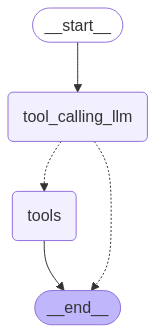

In [133]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([average_dog_weight, add]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="How much does a toy poodle weigh?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

NameError: name 'graph' is not defined

In [135]:
messages = [HumanMessage(content="Hello how are you doing?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello how are you doing?
================================== Ai Message ==================================

I'm doing well, thank you for asking. Is there something I can help you with, or would you like to know more about a specific dog breed or perhaps perform some calculations?


In [136]:
messages = [HumanMessage(content="I have 2 dogs, a border collie and a scottish terrier. What is their combined weight")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I have 2 dogs, a border collie and a scottish terrier. What is their combined weight
================================== Ai Message ==================================
Tool Calls:
  average_dog_weight (call_ekkj)
 Call ID: call_ekkj
  Args:
    name: Border Collie
  average_dog_weight (call_28hn)
 Call ID: call_28hn
  Args:
    name: Scottish Terrier
  add (call_k603)
 Call ID: call_k603
  Args:
    a: 37
    b: 20
================================= Tool Message =================================
Name: average_dog_weight

a Border Collies average weight is 37 lbs
================================= Tool Message =================================
Name: average_dog_weight

Scottish Terriers average 20 lbs
================================= Tool Message =================================
Name: add

57


Notice that due to how we constructed our graph, the LLM does not get to see the tool output again, so it can't answer the question in a nice manner - we just get the tool output. To resolve this we want to connect the tool output back to the llm.

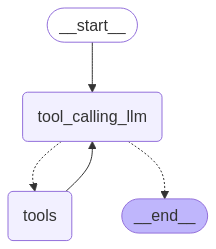

In [137]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([average_dog_weight, add]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [138]:
messages = [HumanMessage(content="I have 2 dogs, a border collie and a scottish terrier. What is their combined weight")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I have 2 dogs, a border collie and a scottish terrier. What is their combined weight
================================== Ai Message ==================================
Tool Calls:
  average_dog_weight (call_epm2)
 Call ID: call_epm2
  Args:
    name: Border Collie
  average_dog_weight (call_13ee)
 Call ID: call_13ee
  Args:
    name: Scottish Terrier
  add (call_6zap)
 Call ID: call_6zap
  Args:
    a: 37
    b: 20
================================= Tool Message =================================
Name: average_dog_weight

a Border Collies average weight is 37 lbs
================================= Tool Message =================================
Name: average_dog_weight

Scottish Terriers average 20 lbs
================================= Tool Message =================================
Name: add

57
================================== Ai Message ==================================

The combined weight of your Border 

Let's look at this on LangSmith https://smith.langchain.com

![images/Langsmith.png](images/Langsmith.png)
 


In [ ]:
messages = [HumanMessage(content="Ah I forgot my Husky. Please add its weight.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Ah I forgot my Husky. Please add its weight.
================================== Ai Message ==================================
Tool Calls:
  average_dog_weight (call_xp0p)
 Call ID: call_xp0p
  Args:
    name: Siberian Husky
  add (call_cn6q)
 Call ID: call_cn6q
  Args:
    a: 50
    b: 23
================================= Tool Message =================================
Name: average_dog_weight

An average dog weights 50 lbs
================================= Tool Message =================================
Name: add

73
================================== Ai Message ==================================

The average weight of a Siberian Husky is 23 lbs, so if we add that to the default weight of 50 lbs, we get 73 lbs.


We can tell that our model does not remember our previous query about the two dogs that we already asked it about.

### Let's add memory
  
As the husky example shows, our current graph does not have any notion of what came before in our previous invocation.

In [43]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [44]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="I have 2 dogs, a border collie and a scottish terrier. What is their combined weight")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I have 2 dogs, a border collie and a scottish terrier. What is their combined weight
================================== Ai Message ==================================
Tool Calls:
  average_dog_weight (call_3j22)
 Call ID: call_3j22
  Args:
    name: Border Collie
  average_dog_weight (call_2h4d)
 Call ID: call_2h4d
  Args:
    name: Scottish Terrier
  add (call_897q)
 Call ID: call_897q
  Args:
    a: 37
    b: 20
================================= Tool Message =================================
Name: average_dog_weight

a Border Collies average weight is 37 lbs
================================= Tool Message =================================
Name: average_dog_weight

Scottish Terriers average 20 lbs
================================= Tool Message =================================
Name: add

57
================================== Ai Message ==================================

The combined weight of your Border 

In [45]:
messages = [HumanMessage(content="Ah I forgot my Husky. Please add its weight.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I have 2 dogs, a border collie and a scottish terrier. What is their combined weight
================================== Ai Message ==================================
Tool Calls:
  average_dog_weight (call_3j22)
 Call ID: call_3j22
  Args:
    name: Border Collie
  average_dog_weight (call_2h4d)
 Call ID: call_2h4d
  Args:
    name: Scottish Terrier
  add (call_897q)
 Call ID: call_897q
  Args:
    a: 37
    b: 20
================================= Tool Message =================================
Name: average_dog_weight

a Border Collies average weight is 37 lbs
================================= Tool Message =================================
Name: average_dog_weight

Scottish Terriers average 20 lbs
================================= Tool Message =================================
Name: add

57
================================== Ai Message ==================================

The combined weight of your Border 

To allow us to create more complicated graphs we need to take a closer look at state management.
 
## State Management and Reducers
 
By default we simply override the state of our graph.

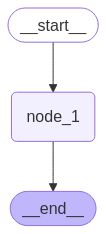

In [46]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
print(graph.invoke({"foo" : 1}))
# Note that even if we call this multiple times the value does not increase.
print(graph.invoke({"foo" : 1}))

---Node 1---
{'foo': 2}
---Node 1---
{'foo': 2}


## Branching

Let's look at a case where our nodes branch.

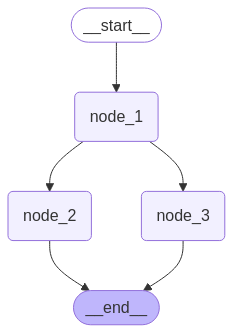

In [48]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We see a problem! 

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*. 

This is ambiguous for the graph! Which state should it keep? 

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

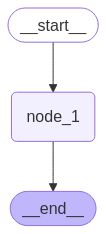

In [50]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list. 

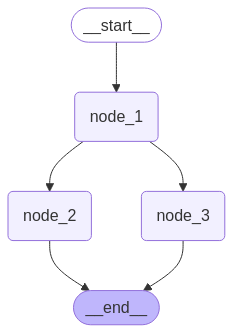

In [52]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [53]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Combining reducers and memory allows us to form ever longer chains, but we need to manage these to avoid token usage and therefore latency and cost to grow beyond a reasonable point.
## Messages

In [54]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

In [55]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1d7c81fd-b581-4ea9-b5e2-b000396621ae'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='37f3a810-0f22-4b98-8745-7dbf5702fa89'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='36489929-0aeb-4e86-bf8c-970600f7c09c')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [56]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [57]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [58]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

Now we can apply this to our messages with LLMs. We likely want to limit the length of a message chain to both reduce latency and cost by removing the overall token usage.

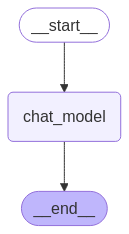

In [59]:
llm = create_chat_model()

from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life on land and in the water. They're skilled swimmers and can be found in oceans a

### The simplest method of reducing the number of messages sent is just sending k many messages

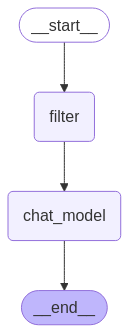

In [61]:
from langchain_core.messages import RemoveMessage

k = -2

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:k]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful nature and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life in the water, with flippers and a streamlined body. They're found in oceans around the world and are known for their agility and playful behavior.
3. **Walruses**: With their distinctive tusks and blubbery bodies, walruses are well-suited to life in the Arctic and sub-Arctic

In [63]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful nature and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life in the water, with flippers and a streamlined body. They're found in oceans aroun

In [64]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================

There are many fascinating ocean mammals beyond whales. Here are a few you might find interesting:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful nature and ability to communicate with each other using clicks and whistles.
2. **Seals and Sea Lions**: These fin-footed mammals are adapted to life in the water, with flippers and a streamlined body. They're found in oceans around the world and are known for their agility and playful behavior.
3. **Walruses**: With their distinctive tusks and blubbery bodies, walruses are well-suited to life in the Arctic and sub-Arctic oceans. They're skilled divers and can be found in large herds.
4. **Manatees**: Also known as sea cows, manatees are large, gentle creatures that graze on seaweed and seagrass in shallow waters. They're found in warm, coastal waters around the world.
5. **Dugongs**: Similar to manatees, dugongs 

#### Summary 
 
Just trimming our conversation might not always be a great idea therefore we can use an LLM to summarize our conversation and reduce token usage that way

In [65]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str
    
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [66]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

We can also add memory to this.

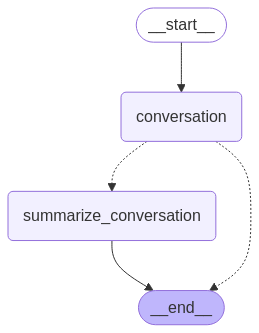

In [67]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance, it's nice to meet you. Is there something I can help you with or would you like to chat?
================================== Ai Message ==================================

Your name is Lance. You told me that when you said "hi" earlier.
================================== Ai Message ==================================

A 49ers fan, eh? That's great, Lance! The San Francisco 49ers have a rich history in the NFL, with five Super Bowl wins. Who's your favorite player, past or present?


In [69]:
# At this stage we will not have a summary, as our graph only summarizes after 6 messages
graph.get_state(config).values.get("summary","")

''

In [70]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nick Bosa is an excellent choice, Lance. He's a talented defensive end and a key player for the 49ers. As for being the highest-paid defensive player, that's close, but not quite accurate. Nick Bosa did sign a massive contract extension with the 49ers in 2023, but I think Aaron Donald of the Los Angeles Rams currently holds the title of highest-paid defensive player in the NFL. However, Bosa's contract is certainly one of the most lucrative for a defensive player, and he's definitely worth every penny given his impressive performance on the field!


In [71]:
graph.get_state(config).values.get("summary","")

"Here's a summary of our conversation:\n\n* You introduced yourself as Lance and we started chatting.\n* I recalled your name and confirmed it when you asked.\n* You mentioned that you're a fan of the San Francisco 49ers.\n* You expressed your admiration for Nick Bosa, a defensive end for the 49ers, and asked if he's the highest-paid defensive player (I clarified that while he has a lucrative contract, Aaron Donald currently holds that title)."

At this stage we have only used in-memory databases. For more persistence, you could also add a more permanent database like SQLite

## Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [5]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="What is the capitol of germany? Tell me its history")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"].get("chunk").content, end="")

NameError: name 'graph' is not defined

## Human in the Loop
 
In many cases we likely don't want the agent to be able to perform an action without a user having checked the action plan beforehand. Think of terminal commands, customer service emails etc. In these cases we want to make sure that, for example, the agent did actually answer the question the customer asked in their email or that the terminal command the agent wants to run is actually safe to run and does not have any unwanted side effects.

In [6]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

NameError: name 'graph' is not defined

### Dummy Node
 
Another way we can quite easily add human feedback to our graph is by adding a node that takes in human input and injects that input into the state as if it were a regular node.

In [76]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = create_chat_model()
llm_with_tools = llm.bind_tools(tools)

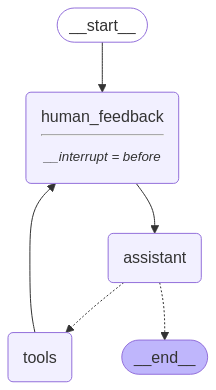

In [77]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

We will get feedback from the user.

We use `.update_state` to update the state of the graph with the human response we get, as before.

We use the `as_node="human_feedback"` parameter to apply this state update as the specified node, `human_feedback`.

In [78]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No do 4*5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_tfge)
 Call ID: call_tfge
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: multiply

20


# Lets now build a multi Agent Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [103]:
# To avoid rate limits we will use OpenAi here
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [104]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

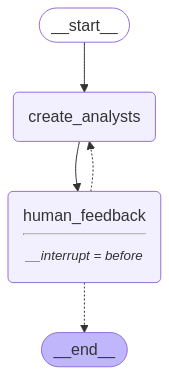

In [105]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [106]:
# Input
max_analysts = 3 
topic = "Literature Topic: Generalist Agents and Agent Benchmarks"
thread = {"configurable": {"thread_id": "4"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: AI Research Institute
Role: Generalist Agent Development Specialist
Description: Dr. Carter focuses on the development of generalist agents, exploring how these agents can be designed to perform a wide range of tasks across different domains. Her work involves understanding the underlying architectures that enable such versatility and the potential applications of these agents in real-world scenarios.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: Benchmarking Standards Organization
Role: Agent Benchmarking Expert
Description: Mr. Smith is dedicated to establishing and refining benchmarks for evaluating the performance of generalist agents. He is concerned with creating standardized tests that can accurately measure the capabilities of these agents across various tasks, ensuring that comparisons between different systems are fair and meaningful.
--------------------------------------------------
Name: Prof. Sarah

In [107]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [108]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f006416-9286-6996-8002-0b3c32bfde72'}}

In [109]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: AI Research Institute
Role: Generalist Agent Development Specialist
Description: Dr. Carter focuses on the development of generalist agents, exploring how these agents can be designed to perform a wide range of tasks across different domains. Her work involves understanding the underlying architectures that enable such versatility and the potential applications of these agents in real-world scenarios.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: Benchmarking Standards Organization
Role: Agent Benchmarking Expert
Description: Mr. Smith is dedicated to establishing and refining benchmarks for evaluating the performance of generalist agents. He is concerned with creating standardized tests that can accurately measure the capabilities of these agents across various tasks, ensuring that comparisons between different systems are fair and meaningful.
--------------------------------------------------
Name: Prof. Sarah

In [110]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1f006416-e087-67db-8004-ec63b3389b3e'}}

In [111]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

final_state.next

()

In [112]:
# Lets display our final analyst team
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: OpenAI
Role: AI Researcher
Description: Dr. Carter focuses on the development and evaluation of generalist agents. She is particularly interested in how these agents can be benchmarked effectively to ensure they perform well across a variety of tasks. Her work involves creating new metrics and testing environments to push the boundaries of what generalist agents can achieve.
--------------------------------------------------
Name: Professor Alan Nguyen
Affiliation: Stanford University
Role: Academic Scholar
Description: Professor Nguyen's research delves into the theoretical underpinnings of agent benchmarks. He is concerned with the philosophical and ethical implications of creating agents that can perform a wide range of tasks. His work often explores the balance between generalization and specialization in AI systems, and how benchmarks can be designed to reflect real-world complexities.
--------------------------------------------------
Name: Sam

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [113]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [114]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [115]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults


tavily_search = TavilySearchResults(
    max_results=3
)

# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

In [139]:
# Test that tavily is working correctly 
tavily_search("What are agents?")

[{'url': 'https://www.merriam-webster.com/dictionary/agent',
  'content': 'agent\nnoun\nˈā-jənt \xa0\nplural agents\nSynonyms of agent\n1\n: one that acts or exerts power\n2\na\n: something that produces or is capable of producing an effect : an active or efficient cause\nEducation proved to be an agent of change in the community.\nb\n: a chemically, physically, or biologically active principle\nan oxidizing agent\n3\n: a means or instrument by which a guiding intelligence achieves a result\n4\n: one who is authorized to act for or in the place of another: such as\na [...] see also innocent agent\n3\na\n: a person or entity (as an employee or independent contractor) authorized to act on behalf of and under the control of another in dealing with third parties see also agency sense 2, fiduciary relationship, subagent compare fiduciary, principal, servant\n— apparent agent\n: an agent acting under an agency by estoppel\n— bargaining agent\n: a labor union that represents the employees in 

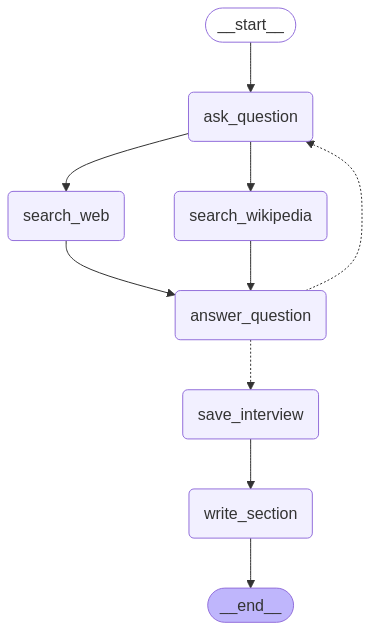

In [117]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [118]:
# Pick one analyst
analysts[0]

Analyst(affiliation='OpenAI', name='Dr. Emily Carter', role='AI Researcher', description='Dr. Carter focuses on the development and evaluation of generalist agents. She is particularly interested in how these agents can be benchmarked effectively to ensure they perform well across a variety of tasks. Her work involves creating new metrics and testing environments to push the boundaries of what generalist agents can achieve.')

In [141]:
# Remember our topic
topic

'Please write a seminar report for the following topic Literature Topic: Web Agents and Web Agent Benchmarks'

In [119]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Pushing the Boundaries: Benchmarking Generalist AI Agents

### Summary

In the rapidly evolving field of artificial intelligence, the development and evaluation of generalist agents are crucial for ensuring these systems can perform effectively across a wide range of tasks. Generalist agents, unlike their specialist counterparts, are designed to handle diverse tasks, making their benchmarking a complex yet essential process. Dr. Carter's work focuses on creating new metrics and testing environments to push the boundaries of what these agents can achieve. This report synthesizes insights from various sources to highlight the current state and challenges in benchmarking generalist AI agents.

One of the primary challenges in developing generalist agents is their performance in real-world scenarios. Current AI agents often struggle with complex professional tasks, indicating a need for further advancements [1]. The autonomous nature of AI agents makes it easier to create benchmarks and test them on common tasks, yet these benchmarks must reflect the diverse and dynamic nature of real-world work environments [2]. Traditional benchmarks often fail to capture these dynamic aspects, as they evaluate agents in static scenarios that do not reflect the frequent updates and changes in real-world applications [3].

TheAgentCompany's benchmark framework addresses some of these challenges by offering tasks that require multiple steps, mimicking the complexity of real professional work. This framework emphasizes the need for AI agents to interact with various tools used in workplaces, such as web interfaces and communication tools [2]. Moreover, innovative evaluation metrics and refined datasets, like those introduced by the WebCanvas framework, aim to provide a more realistic assessment of web agents by capturing the dynamic nature of web interactions [3].

To effectively evaluate AI agents, a balanced approach that considers both general performance and agent-specific capabilities is necessary. Metrics such as correctness, instruction adherence, and tool interaction are crucial for assessing how well an agent communicates and performs its tasks [4]. These metrics set a baseline for measuring AI agent performance, ensuring that they produce high-quality outputs that meet set standards.

In conclusion, the development of effective benchmarking frameworks is vital for advancing generalist AI agents. By addressing the limitations of current benchmarks and incorporating dynamic, real-world scenarios, researchers can better evaluate and improve the capabilities of these agents, ultimately pushing the boundaries of what they can achieve.

### Sources
[1] https://www.linkedin.com/pulse/benchmarking-autonomous-ai-agents-new-class-iq-task-raymond-omahc  
[2] https://cobusgreyling.medium.com/the-battle-of-ai-agents-comparing-real-world-performance-using-benchmarking-356a8c6e0fcc  
[3] https://medium.com/@iMeanAI/comparing-top3-ai-web-agent-benchmark-platforms-frameworks-fe01dc7d4ba5  
[4] https://www.galileo.ai/blog/evaluating-ai-agent-performance-benchmarks-real-world-tasks  

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [120]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

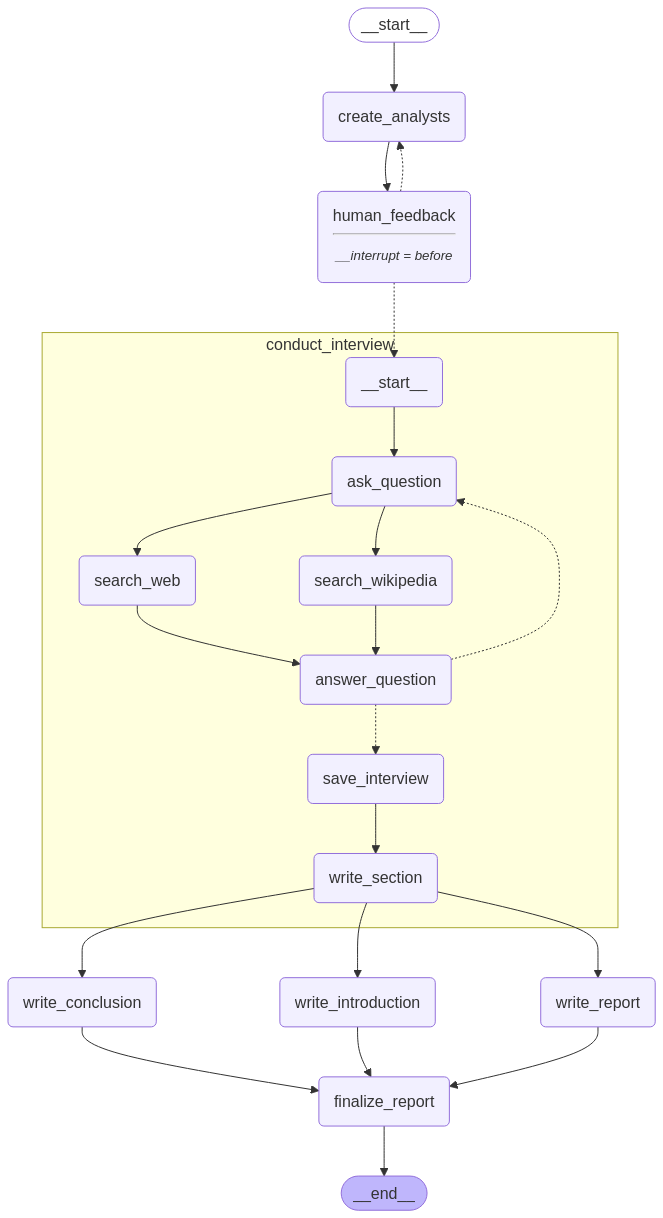

In [121]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let us now write our report 

In [ ]:
# Inputs
max_analysts = 3 
topic = "Literature Topic: Web Agents and Web Agent Benchmarks"
thread = {"configurable": {"thread_id": "6"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: University of Technology
Role: Web Agent Researcher
Description: Dr. Carter focuses on the development and evolution of web agents, exploring how they can be designed to perform complex tasks autonomously. Her primary concern is ensuring that these agents are efficient, reliable, and capable of adapting to new web environments. She is motivated by the potential of web agents to revolutionize how information is processed and utilized on the internet.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: TechBench Labs
Role: Benchmark Specialist
Description: Mr. Smith specializes in creating and evaluating benchmarks for web agents. His focus is on developing standardized tests that can accurately measure the performance and capabilities of different web agents. He is concerned with ensuring that benchmarks are comprehensive and reflect real-world scenarios. His motivation is to provide a fair and objective means of compa

In [123]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Please add more computer science experts"}, as_node="human_feedback")

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1f006419-bccb-6680-8002-cdd607a980d0'}}

In [124]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: University of Technology
Role: Web Agent Researcher
Description: Dr. Carter focuses on the development and evolution of web agents, exploring how they can be designed to perform complex tasks autonomously. Her primary concern is ensuring that these agents are efficient, reliable, and capable of adapting to new web environments. She is motivated by the potential of web agents to revolutionize how information is processed and utilized on the internet.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: TechBench Labs
Role: Benchmark Specialist
Description: Mr. Smith specializes in creating and evaluating benchmarks for web agents. His focus is on developing standardized tests that can accurately measure the performance and capabilities of different web agents. He is concerned with ensuring that benchmarks are comprehensive and reflect real-world scenarios. His motivation is to provide a fair and objective means of compa

In [125]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00641a-0f08-6d06-8004-73c2f3cacb01'}}

In [126]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [127]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Advancing Web Agents: Challenges and Innovations in Benchmarking

## Introduction

In the dynamic landscape of artificial intelligence, web agents are at the forefront of automating online tasks, from e-commerce to data analysis. This report explores the challenges and innovations in benchmarking these agents, emphasizing the need for robust evaluation metrics. We delve into the evolution of benchmarks from static datasets to dynamic environments, highlighting the importance of data quality and innovative techniques like large language models (LLMs) for annotation. The report also examines frameworks such as GuardAgent and AutoGen, which enhance agent safety and trustworthiness, and discusses ServiceNow's AgentLab, a pivotal tool for agent evaluation. Finally, we consider the integration of LLMs in agent modeling, underscoring their potential to simulate human-like interactions.

---



The development and evaluation of web agents, autonomous tools designed to perform tasks on the internet, are rapidly advancing within the field of artificial intelligence. These agents are increasingly integrated into applications ranging from online shopping to complex data analysis. However, their performance in dynamic online environments remains a significant challenge. Effective testing, benchmarking, and evaluation are crucial for assessing web agents' behavior in diverse scenarios. Traditional benchmarks have evolved from offline datasets to more dynamic online environments, yet they still lack comprehensive coverage of critical dimensions necessary for meaningful evaluations [1]. The quality of data used in these benchmarks is crucial, as redundant or irrelevant tasks do not provide valuable insights into an agent's capabilities [2]. Innovative techniques, such as recording real work and using large language models (LLMs) for automatic annotation, are being explored to enhance the quality and relevance of these benchmarks [2].

Despite advancements, web agents are still far from achieving human-level performance, particularly in complex or dynamic environments. They are more error-prone compared to humans, highlighting the need for more sophisticated and realistic benchmarks [2]. The development of frameworks like GuardAgent and AutoGen, which incorporate knowledge reasoning and multi-agent conversations, respectively, aim to enhance the safety and trustworthiness of web agents [2]. ServiceNow's release of AgentLab, an open-source Python package, represents a significant step forward in the development and evaluation of web agents. This tool provides a platform for researchers to test and benchmark web agents in a controlled environment, addressing some of the challenges associated with evaluating these agents in real-world scenarios [1].

The integration of LLMs into agent-based modeling and simulation is another promising avenue for enhancing the capabilities of web agents. By leveraging LLMs, web agents can better simulate human behaviors and interact with websites using natural language instructions, thus improving their performance in real-world applications [3]. Recent advancements in LLM-based web agents have introduced novel architectures and benchmarks that showcase progress in autonomous web navigation and interaction. However, existing benchmarks often prioritize effectiveness and accuracy, overlooking crucial factors like safety and trustworthiness, which are essential for deploying web agents in enterprise settings [1]. The risks of unsafe web agent behavior, such as accidentally deleting user accounts or performing unintended actions in critical environments, underscore the need for comprehensive evaluation metrics [1].

A notable development in this area is the introduction of ST-WebAgentBench, which includes evaluation metrics specifically designed to assess agents' safety and trustworthiness. This benchmark provides a more comprehensive evaluation by incorporating dynamic user and tool interactions, policy adherence, and human-in-the-loop tasks. It addresses the need for agents to interact seamlessly with both humans and programmatic APIs over long horizons, follow complex policies, and maintain consistency and reliability at scale [1]. Despite the promise of autonomous web agents, they are still far from achieving human-level performance in many scenarios. Studies show that web agents are more error-prone compared to humans when performing the same tasks, particularly in complex or dynamic environments. Benchmarks have evolved from offline datasets, such as Mind2Web, to online environments like WebArena, which simulate real-world interactions [1].

The lack of standardization in evaluation practices poses challenges for reproducibility and the comparison of results across different studies. This lack of standardization hinders the identification of genuine improvements and can mislead developers when selecting agents for specific applications. Sierra’s 𝜏-bench is another benchmark designed to evaluate AI agents’ performance and reliability in real-world settings, addressing these standardization issues [2]. The emergence of web agent benchmarks has significantly accelerated the development of web agents. Some of these agents are fine-tuned for specific tasks, while others are built on frontier models like AutoGPT. The ease of creating new agents, thanks to frameworks like AutoGen and LangGraph, has led to the rapid introduction of numerous state-of-the-art agents, many of which have quickly surpassed existing capabilities [1]. These frameworks enable the development of highly adaptive conversational experiences through customizable agents, ideal for large-scale LLM applications with dynamic interactions and human feedback loops [4].

Benchmarking plays a critical role in accelerating AI agent adoption in enterprise settings by providing an objective basis for decision-making. It enables enterprises to verify performance claims and make confident, informed choices that support operational scalability and maintainability [2]. To design effective benchmarks, it is crucial to understand the unique challenges posed to and by AI agents in enterprise environments. This includes addressing issues of reproducibility, bias, and real-world applicability [2]. The integration of web agents into commercial applications holds the potential to transform online interactions and business processes. By leveraging cutting-edge research and practical applications, benchmarks can improve the scalability and adaptability of web agents, ensuring their safe and effective deployment in real-world scenarios.


---

## Conclusion

The exploration of web agents and their benchmarks reveals a dynamic landscape marked by both challenges and innovations. As highlighted, the development of robust web agents is crucial for their effective deployment in diverse applications, from online shopping to complex data analysis. The introduction of tools like ServiceNow's AgentLab and frameworks such as GuardAgent and AutoGen underscores the progress in creating safer and more reliable agents. However, the need for comprehensive benchmarks that prioritize safety and trustworthiness remains critical. By advancing benchmarking techniques and integrating large language models, the field can overcome existing limitations, ensuring web agents meet industry standards and transform online interactions effectively.

## Sources
[1] https://www.marktechpost.com/2024/12/04/servicenow-releases-agentlab-a-new-open-source-python-package-for-developing-and-evaluating-web-agents/  
[2] https://arxiv.org/html/2410.06703v2  
[3] https://www.nature.com/articles/s41599-024-03611-3  
[4] https://www.linkedin.com/pulse/deep-dive-langgraph-vs-autogen-detailed-comparison-ravi-gupta-dzkrf